In [36]:
from langgraph.graph import START, END, StateGraph
from langgraph.types import Send, interrupt
from typing import TypedDict
import subprocess
from openai import OpenAI
import textwrap
from langchain.chat_models import init_chat_model
from typing_extensions import Annotated
import operator
import base64
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

llm = init_chat_model("openai:gpt-5-mini-2025-08-07")


class State(TypedDict):
    video_file: str
    audio_file: str
    transcription: str
    summaries: Annotated[list[str], operator.add]
    thnmbnail_prompts: Annotated[list[str], operator.add]
    thnmbnail_sketches: Annotated[list[str], operator.add]
    final_summary: str
    user_feedback: str
    chosen_prompt: str

In [37]:
def extract_audio(state: State):
    output_file = state["video_file"].replace(".mp4", ".mp3")
    command = [
        "ffmpeg",
        "-i",
        state["video_file"],
        "-filter:a",
        "atempo=2.0",
        output_file,
        "-y",
    ]
    subprocess.run(command)
    return {"audio_file": output_file}


def transcribe_audio(state: State):
    client = OpenAI()
    with open(state["audio_file"], "rb") as audio:
        transcription = client.audio.transcriptions.create(
            model="whisper-1",
            response_format="text",
            file=audio,
            language="ko",
            prompt="아이엠랩, 설우석",
        )
        return {"transcription": transcription}


def dispatch_summarizers(state: State):
    transcription = state["transcription"]
    chunks = []
    for i, chunk in enumerate(textwrap.wrap(transcription, width=200)):
        chunks.append({"id": i + 1, "chunk": chunk})
    return [Send("summarize_chuck", chunk) for chunk in chunks]


def summarize_chuck(chunk: dict):
    id = chunk["id"]
    chunk = chunk["chunk"]

    response = llm.invoke(
        f"""
        Please summarize the following text:

        TEXT: {chunk}
        """
    )
    summary = f"[Chunk {id}] {response.content}"
    return {
        "summaries": [summary],
    }


def final_summary(state: State):
    all_summaries = "\n".join(state["summaries"])

    prompt = f"""
        You are given multiple summaries of different chunks from a video transcriptions.

        Please create a comprehensive final summary that combines all the key points.

        Individual summaries:

        {all_summaries}
    """

    response = llm.invoke(prompt)
    return {"final_summary": response.content}


def dispatch_artists(state: State):
    return [
        Send("generate_thumbnails", {"id": i, "summary": state["final_summary"]})
        for i in [1, 2, 3, 4]
    ]


def generate_thumbnails(args):
    id = args["id"]
    summary = args["summary"]

    prompt = f"""
    Based on this video summary, create a detailed visual prompt for a YouTube thumbnail.

    Create a detailed prompt for generating a thunbnail image that would attract viewers. Include:
        - Main visual elements
        - Color scheme
        - Text overlay suggestions
        - Overall composition

    VIDEO SUMMARY: {summary}
    """

    response = llm.invoke(prompt)

    thnmbnail_prompt = response.content

    client = OpenAI()

    result = client.images.generate(
        model="gpt-image-1-mini",
        prompt=thnmbnail_prompt,
        quality="low",
        moderation="low",
        size="auto",
    )

    image_bytes = base64.b64decode(result.data[0].b64_json)

    filename = f"thumbnail_{id}.png"

    with open(filename, "wb") as f:
        f.write(image_bytes)

    return {
        "thnmbnail_prompts": [thnmbnail_prompt],
        "thnmbnail_sketches": [filename],
    }


def human_feedback(state: State):
    answer = interrupt(
        {
            "chosen_thumbnail": "Which thumbnail do you like?",
            "feedback": "Provide any feedback or changes you'd like for the final thumbnail.",
        }
    )

    user_feedback = answer["user_feedback"]
    chosen_prompt = answer["chosen_prompt"]

    return {
        "user_feedback": user_feedback,
        "chosen_prompt": state["thnmbnail_prompts"][chosen_prompt - 1],
    }


def generate_hd_thumbnail(state: State):
    chosen_prompt = state["chosen_prompt"]
    user_feedback = state["user_feedback"]

    prompt = f"""
    You are a professional YouTube thumbnail designer. Take this original thumbnail prompt and create an enhanced version that incorporates the user's specific feedback.

    ORIGINAL PROMPT:
    {chosen_prompt}

    USER FEEDBACK TO INCORPORATE:
    {user_feedback}

    Create an enhanced prompt that:
        1. Maintains the core concept from the original prompt
        2. Specifically addresses and implements the user's feedback requests
        3. Adds professional YouTube thumbnail specifications:
            - High contrast and bold visual elements
            - Clear focal points that draw the eye
            - Professional lighting and composition
            - Optimal text placement and readability with generous padding from edges
            - Colors that pop and grab attention
            - Elements that work well at small thumbnail sizes
            - IMPORTANT: Always ensure adequate white space/padding between any text and the image borders
    """

    response = llm.invoke(prompt)

    final_thumbnail_prompt = response.content

    client = OpenAI()

    result = client.images.generate(
        model="gpt-image-1",
        prompt=final_thumbnail_prompt,
        quality="high",
        moderation="low",
        size="auto",
    )

    image_bytes = base64.b64decode(result.data[0].b64_json)

    with open("thumbnail_final.jpg", "wb") as file:
        file.write(image_bytes)


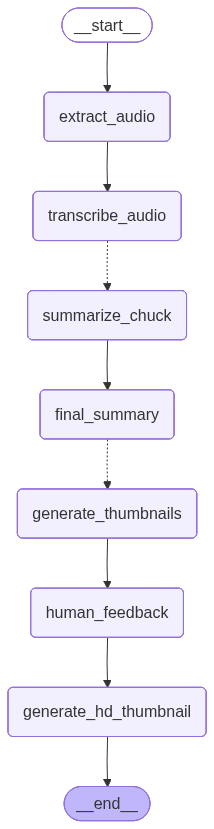

In [38]:
graph_builder = StateGraph(State)

graph_builder.add_node("extract_audio", extract_audio)
graph_builder.add_node("transcribe_audio", transcribe_audio)
graph_builder.add_node("summarize_chuck", summarize_chuck)
graph_builder.add_node("final_summary", final_summary)
graph_builder.add_node("generate_thumbnails", generate_thumbnails)
graph_builder.add_node("human_feedback", human_feedback)
graph_builder.add_node("generate_hd_thumbnail", generate_hd_thumbnail)

graph_builder.add_edge(START, "extract_audio")
graph_builder.add_edge("extract_audio", "transcribe_audio")
graph_builder.add_conditional_edges(
    "transcribe_audio", dispatch_summarizers, ["summarize_chuck"]
)
graph_builder.add_edge("summarize_chuck", "final_summary")
graph_builder.add_conditional_edges(
    "final_summary", dispatch_artists, ["generate_thumbnails"]
)
graph_builder.add_edge("generate_thumbnails", "human_feedback")
graph_builder.add_edge("human_feedback", "generate_hd_thumbnail")
graph_builder.add_edge("generate_hd_thumbnail", END)

graph = graph_builder.compile(checkpointer=memory)

config = {
    "configurable": {
        "thread_id": "1",
    },
}

graph


In [39]:
graph.invoke(
    {"video_file": "cpr_education.mp4"},
    config=config,
)

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

{'video_file': 'cpr_education.mp4',
 'audio_file': 'cpr_education.mp3',
 'transcription': '안녕하세요. 아이엠랩의 심폐소생술 강사, 설우석입니다. 오늘은 심폐소생술이 무엇인지, 어떻게 수행하는지 배워보겠습니다. 우리나라에서는 최근 심정지의 발생률이 증가하고 있는 추세인데요. 질병관리본부의 조사 결과에 따르면 한 해 동안 인구 10만 명장, 45명이 급성 심정지의 상황에 놓입니다. 우리나라의 한 해 심정지 사망자는 2만 9천여 명으로 교통사고 사망자의 약 5배, 더 이상 남의 일이라고 볼 수 없습니다. 심정지 발생 장소를 살펴보면 80% 정도가 가정과 공공장소, 즉 여러분들이 주로 생활하는 공간에서 발생한다고 볼 수 있죠. 만약 여러분의 가족이나 주변 사람에게 심정지가 발생한다면 어떻게 하시겠습니까? 심정지 환자를 구할 수 있는 유일한 방법은 바로 심폐소생술입니다. 심정지가 발생하면 혈액순환이 즉시 중단됩니다. 심폐소생술은 정지된 심장을 대신하여 심장과 뇌에 산소가 포함된 혈액을 공급해주는 아주 중요한 긴급처치입니다. 심정지가 발생한 사람을 살리려면 무엇보다 신속하게 심폐소생술을 하는 것이 중요합니다. 심정지 발생부터, 가능한 빨리, 늦어도 5분 내에 심폐소생술이 시작되어야 생존 가능성이 높아집니다. 우리는 그 5분을 생명의 골든타임이라 고릅니다. 그렇기 때문에 목격자의 즉각적인 대응이 심정지 환자의 생존률을 높이는 데 매우 중요합니다. 심폐소생술은 구급대원도, 의료진과님, 바로 심정지 발생 환자 옆에 있는 여러분이 시작해야 합니다. 우리나라에서 해마다 발생하는 3만여 명의 심정지 환자 중 생존률은 단 4.8%, 100명 중 단 4명 만이 생존합니다. 최근 심정지 조사 주요 결과에 따르면 우리나라에서 일반인이 심폐소생술을 하는 경우는 12%에 불과합니다. 평균 30%가 넘는 미국, 일본과 비교하면 턱없이 낮은 수치죠. 무엇 때문일까요? 바로 두려움과 망설임 때문입니다. 하지만 기억하세요, 당

In [41]:
from langgraph.types import Command

response = {
    "user_feedback": "텍스트는 한국말로 똑바로 써. 그리고 강사가 마네킹에 압박하는 모습으로.",
    "chosen_prompt": 4,
}

graph.invoke(
    Command(resume=response),
    config=config,
)


{'video_file': 'cpr_education.mp4',
 'audio_file': 'cpr_education.mp3',
 'transcription': '안녕하세요. 아이엠랩의 심폐소생술 강사, 설우석입니다. 오늘은 심폐소생술이 무엇인지, 어떻게 수행하는지 배워보겠습니다. 우리나라에서는 최근 심정지의 발생률이 증가하고 있는 추세인데요. 질병관리본부의 조사 결과에 따르면 한 해 동안 인구 10만 명장, 45명이 급성 심정지의 상황에 놓입니다. 우리나라의 한 해 심정지 사망자는 2만 9천여 명으로 교통사고 사망자의 약 5배, 더 이상 남의 일이라고 볼 수 없습니다. 심정지 발생 장소를 살펴보면 80% 정도가 가정과 공공장소, 즉 여러분들이 주로 생활하는 공간에서 발생한다고 볼 수 있죠. 만약 여러분의 가족이나 주변 사람에게 심정지가 발생한다면 어떻게 하시겠습니까? 심정지 환자를 구할 수 있는 유일한 방법은 바로 심폐소생술입니다. 심정지가 발생하면 혈액순환이 즉시 중단됩니다. 심폐소생술은 정지된 심장을 대신하여 심장과 뇌에 산소가 포함된 혈액을 공급해주는 아주 중요한 긴급처치입니다. 심정지가 발생한 사람을 살리려면 무엇보다 신속하게 심폐소생술을 하는 것이 중요합니다. 심정지 발생부터, 가능한 빨리, 늦어도 5분 내에 심폐소생술이 시작되어야 생존 가능성이 높아집니다. 우리는 그 5분을 생명의 골든타임이라 고릅니다. 그렇기 때문에 목격자의 즉각적인 대응이 심정지 환자의 생존률을 높이는 데 매우 중요합니다. 심폐소생술은 구급대원도, 의료진과님, 바로 심정지 발생 환자 옆에 있는 여러분이 시작해야 합니다. 우리나라에서 해마다 발생하는 3만여 명의 심정지 환자 중 생존률은 단 4.8%, 100명 중 단 4명 만이 생존합니다. 최근 심정지 조사 주요 결과에 따르면 우리나라에서 일반인이 심폐소생술을 하는 경우는 12%에 불과합니다. 평균 30%가 넘는 미국, 일본과 비교하면 턱없이 낮은 수치죠. 무엇 때문일까요? 바로 두려움과 망설임 때문입니다. 하지만 기억하세요, 당